<a href="https://colab.research.google.com/github/TUCchkul/PyTorch-CNN/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
%cd /content/drive/MyDrive/Pytorch

/content/drive/MyDrive/Pytorch


In [61]:
!pwd

/content/drive/MyDrive/Pytorch


In [62]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import urllib.request as request

In [63]:
class Config:
  def __init__(self):
    self.ROOT_DATA_DIR="hymenoptera_data_new"
    self.EPOCH=50
    self.LEARNING_RATE=0.01
    self.BATCH_SIZE=32
    self.IMAGE_SIZE=(224,224)
    self.DEVICE="cuda" if torch.cuda.is_available() else "CPU"
    print(f"THis notebook is using the device: {self.DEVICE}")
    self.SEED=2022
    self.create_dir(dir_path=self.ROOT_DATA_DIR)
  def create_dir(self, dir_path):
    os.makedirs(dir_path, exist_ok=True)
    print(f"{dir_path} directory is created")


config=Config()

THis notebook is using the device: cuda
hymenoptera_data_new directory is created


In [64]:
data_URL="https://download.pytorch.org/tutorial/hymenoptera_data.zip"

In [65]:
config.create_dir(dir_path=config.ROOT_DATA_DIR)


hymenoptera_data_new directory is created


In [66]:
data_zip_file="data.zip"
data_file_path=os.path.join(config.ROOT_DATA_DIR, data_zip_file)
request.urlretrieve(data_URL,data_file_path)

('hymenoptera_data_new/data.zip', <http.client.HTTPMessage at 0x7f9a705726d0>)

In [67]:
from zipfile import ZipFile

def unzip_file(source: str, dest: str) -> None:
  print(f"Extraction started........")
  with ZipFile(source, "r") as zip_f:
    zip_f.extractall(dest)
  print(f"extracted {source} to {dest}")

In [68]:
unzip_file(data_file_path, config.ROOT_DATA_DIR)

Extraction started........
extracted hymenoptera_data_new/data.zip to hymenoptera_data_new


In [69]:
# Create data loader
!ls hymenoptera_data_new/hymenoptera_data/train

ants  bees


In [70]:
from pathlib import Path

In [71]:
Path("hymenoptera_data_new/hymenoptera_data/train")

PosixPath('hymenoptera_data_new/hymenoptera_data/train')

# Create data loader

In [72]:
train_path=Path("hymenoptera_data_new/hymenoptera_data/train")
test_path=Path("hymenoptera_data_new/hymenoptera_data/val")

mean of each channel of the image for 28,28 img size

mean=sum(value of the pixels)/784

std=(data-mean)/std

In [73]:
mean=torch.tensor([0.5,0.5,0.5])
std=torch.tensor([0.5,0.5,0.5])

In [74]:
train_transforms=transforms.Compose(
    [
     transforms.Resize(config.IMAGE_SIZE),
     transforms.RandomRotation(degrees=20),
     transforms.ToTensor(),
     transforms.Normalize(mean,std)
    ]
)
test_transforms=transforms.Compose(
    [
     transforms.Resize(config.IMAGE_SIZE),
     transforms.ToTensor(),
     transforms.Normalize(mean,std)
    ]
)

In [75]:
train_data=datasets.ImageFolder(root=train_path, transform=train_transforms)
test_data=datasets.ImageFolder(root=test_path, transform=test_transforms)

In [76]:
train_data.class_to_idx

{'ants': 0, 'bees': 1}

In [77]:
label_map=train_data.class_to_idx

In [78]:
train_data

Dataset ImageFolder
    Number of datapoints: 244
    Root location: hymenoptera_data_new/hymenoptera_data/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=tensor([0.5000, 0.5000, 0.5000]), std=tensor([0.5000, 0.5000, 0.5000]))
           )

In [79]:
test_data

Dataset ImageFolder
    Number of datapoints: 153
    Root location: hymenoptera_data_new/hymenoptera_data/val
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=tensor([0.5000, 0.5000, 0.5000]), std=tensor([0.5000, 0.5000, 0.5000]))
           )

In [80]:
train_loader=DataLoader(train_data, shuffle=True, batch_size=config.BATCH_SIZE)
test_loader=DataLoader(test_data, shuffle=False, batch_size=config.BATCH_SIZE)

In [81]:
data=next(iter(train_loader))

In [82]:
len(data)

2

In [83]:
images, labels=data
images.shape

torch.Size([32, 3, 224, 224])

In [84]:
labels.shape

torch.Size([32])

In [85]:
img=images[0]
img.shape

torch.Size([3, 224, 224])

TypeError: ignored

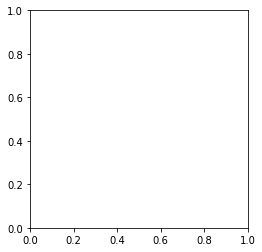

In [86]:
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


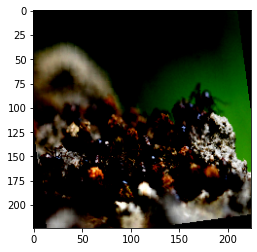

In [87]:
plt.imshow(img.permute(1,2,0))

In [88]:
# Download pretrain model
model=models.alexnet(pretrained=True)

In [89]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [90]:
#Checking how many trainble parameters in a model
def count_params(model):
  model_params={"Modules":list(), "Parameters":list()}
  total={"trainable":0, "non_trainable":0}
  for name, parameters in model.named_parameters():
    param=parameters.numel()
    if not parameters.requires_grad:
      total["non_trainable"] +=param

      continue
    
    model_params["Modules"].append(name)
    model_params["Parameters"].append(param)
    total["trainable"] +=param
  df=pd.DataFrame(model_params)
  df=df.style.set_caption(f"Total trainable parameters: {total}")
  return df
count_params(model)

,Modules,Parameters
0,features.0.weight,23232
1,features.0.bias,64
2,features.3.weight,307200
3,features.3.bias,192
4,features.6.weight,663552
5,features.6.bias,384
6,features.8.weight,884736
7,features.8.bias,256
8,features.10.weight,589824
9,features.10.bias,256


In [91]:
# freeze all the layers
for parameters in model.parameters():
  print(parameters.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [92]:
#making False
for parameters in model.parameters():
  parameters.requires_grad=False

In [93]:
count_params(model)

,Modules,Parameters


In [94]:
# Define our own classifier
model.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [95]:
#inplace =True->
model.classifier=nn.Sequential(
    nn.Linear(in_features=9216, out_features=100, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=100, out_features=2, bias=True)
)

In [96]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Drop

In [97]:
count_params(model)

,Modules,Parameters
0,classifier.0.weight,921600
1,classifier.0.bias,100
2,classifier.3.weight,200
3,classifier.3.bias,2


In [98]:
model.to(config.DEVICE)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Drop

In [99]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters())

In [100]:
for epoch in range(config.EPOCH):
  with tqdm(train_loader) as tqdm_epoch:
    for images, labels in tqdm_epoch:
      tqdm_epoch.set_description(f"Epoch {epoch+1}/{config.EPOCH}")
      images=images.to(config.DEVICE)
      labels=labels.to(config.DEVICE)

      # forward pass
      outputs=model(images)
      loss=criterion(outputs, labels)

      #Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      tqdm_epoch.set_postfix(loss=loss.item())

Epoch 50/50: 100%|██████████| 8/8 [00:02<00:00,  3.40it/s, loss=0.0081]


Evaluate the Model

In [101]:
!pwd

/content/drive/MyDrive/Pytorch


In [102]:
os.makedirs("model_dir_transfer_learning", exist_ok=True)
model_file_path=os.path.join("model_dir_transfer_learning", "CNN_model_AlexNet.pth")
torch.save(model,model_file_path)

In [103]:
loaded_model=torch.load(model_file_path)

In [104]:
pred=np.array([])
target=np.array([])

with torch.no_grad():
  for batch, data in enumerate(test_loader):
    images=data[0].to(config.DEVICE)
    labels=data[1].to(config.DEVICE)

    y_pred=model(images)
    pred=np.concatenate((pred, torch.argmax(y_pred,1).cpu().numpy()))
    target=np.concatenate((target, labels.cpu().numpy()))

In [105]:
cm=confusion_matrix(target, pred)
cm

array([[63,  7],
       [14, 69]])

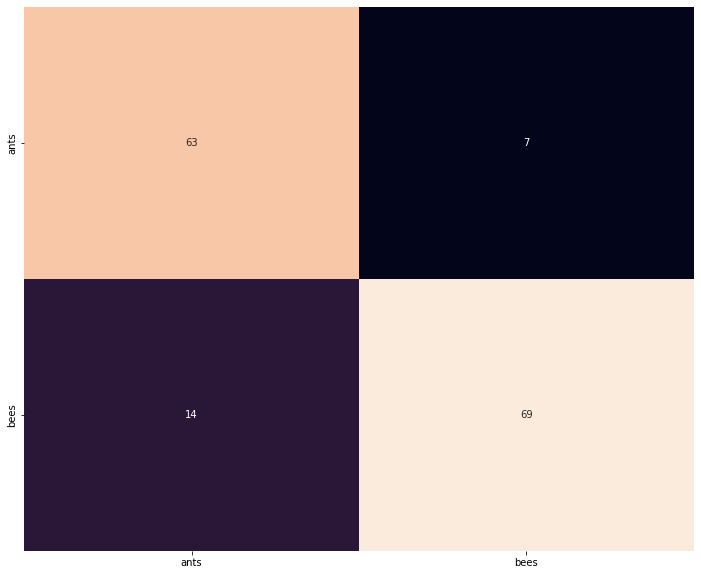

In [107]:
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_map.keys(), yticklabels=label_map.keys(), cbar=False)

In [109]:
data=next(iter(test_loader))
data

[tensor([[[[ 0.6078,  0.5765,  0.7176,  ...,  0.4275,  0.3490,  0.2784],
           [ 0.4667,  0.5373,  0.6078,  ...,  0.4353,  0.4353,  0.3176],
           [ 0.5294,  0.5529,  0.4902,  ...,  0.3569,  0.3569,  0.3569],
           ...,
           [ 0.0980,  0.3490,  0.6941,  ...,  0.2392,  0.2863,  0.6078],
           [ 0.2863,  0.4588,  0.6157,  ...,  0.0667,  0.1059,  0.1922],
           [ 0.2706,  0.3961,  0.5294,  ...,  0.0275,  0.2549,  0.0902]],
 
          [[ 0.9216,  0.8275,  0.8980,  ...,  0.7412,  0.5686,  0.4667],
           [ 0.8353,  0.8745,  0.8980,  ...,  0.7490,  0.6314,  0.4902],
           [ 0.8196,  0.8588,  0.7961,  ...,  0.6706,  0.6157,  0.6157],
           ...,
           [ 0.3255,  0.4510,  0.8588,  ...,  0.3569,  0.4196,  0.7255],
           [ 0.5686,  0.6000,  0.8118,  ...,  0.1843,  0.2392,  0.2549],
           [ 0.5059,  0.6314,  0.7961,  ...,  0.1294,  0.4196,  0.1529]],
 
          [[ 0.9843,  0.8902,  0.9216,  ...,  0.7961,  0.6549,  0.4275],
           [ 

In [110]:
len(data)

2

In [111]:
images, labels=data

In [112]:
images.shape

torch.Size([32, 3, 224, 224])

In [113]:
labels.shape

torch.Size([32])

In [114]:
img=images[2]

In [115]:
img.shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


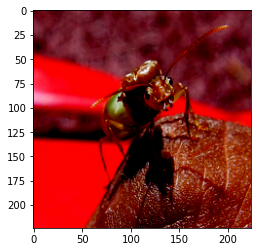

In [116]:
plt.imshow(img.permute(1,2,0))

In [117]:
img.unsqueeze(0).shape

torch.Size([1, 3, 224, 224])

In [119]:
img_on_gpu=img.unsqueeze(0).to(config.DEVICE)
pred_prob=F.softmax(model(img_on_gpu), dim=1)
pred_prob

tensor([[9.9987e-01, 1.2722e-04]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [120]:
argmax=torch.argmax(pred_prob).item()
argmax

0

In [121]:
inv_level_map={val:key for key,val in label_map.items()}
inv_level_map

{0: 'ants', 1: 'bees'}

In [124]:
inv_level_map[argmax],inv_level_map[labels[2].item()]

('ants', 'ants')

In [126]:
def predict(data, model, label_map, device, idx=0):
  images, labels=data
  img=images[idx]
  label=labels[idx]

  plt.imshow(img.permute(1,2,0), cmap="gray")
  img_on_gpu=img.unsqueeze(0).to(config.DEVICE)
  pred_prob=F.softmax(model(img_on_gpu), dim=1)
  argmax=torch.argmax(pred_prob).item()
  predicted_label=label_map[argmax]
  actual_label=label_map[label.item()]
  plt.title(f"actual: {actual_label} | predicted: {predicted_label}")
  plt.axis("off")
  return  predicted_label, actual_label

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('ants', 'ants')

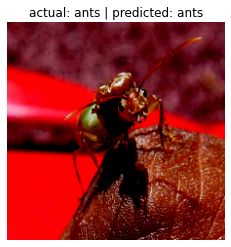

In [127]:
predict(data, model, inv_level_map, config.DEVICE, idx=2)